In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


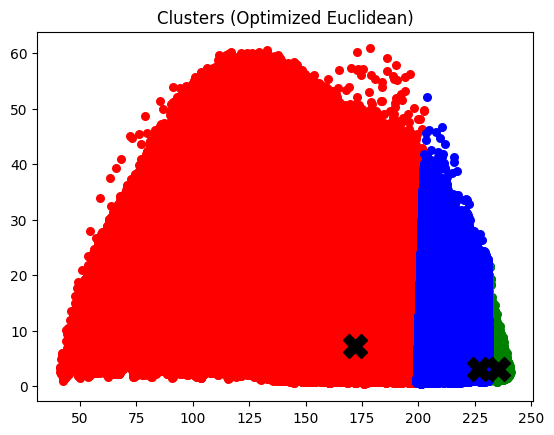

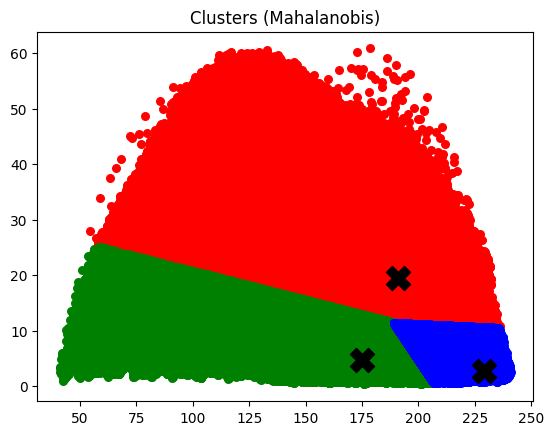

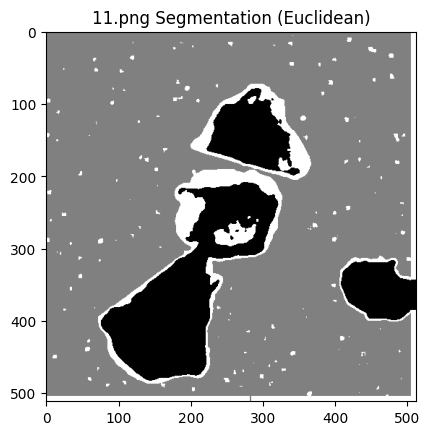

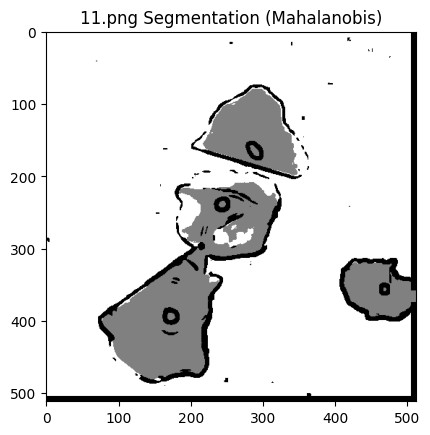

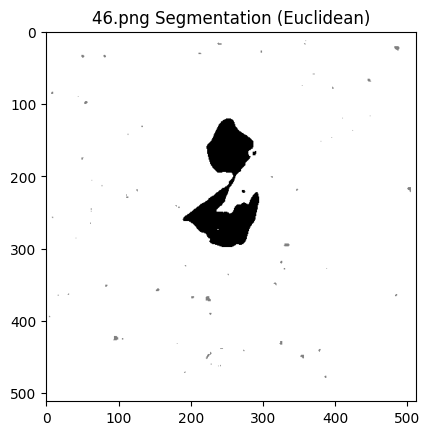

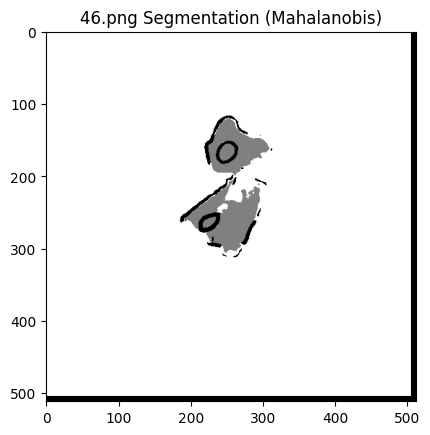

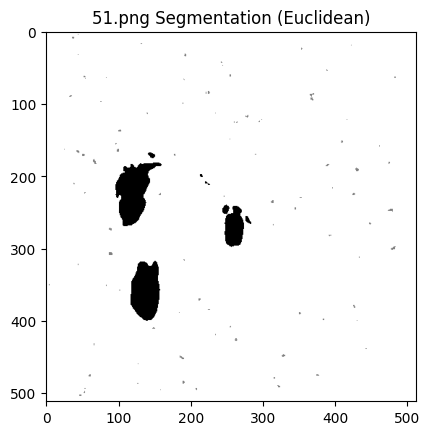

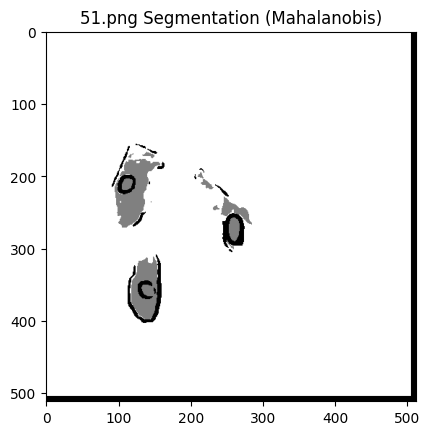

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import cv2

# Helper function to compute mean and standard deviation for each patch
def extract_features(image, patch_size=7, shift=1):
    features = []
    h, w = image.shape

    for i in range(0, h-patch_size+1, shift):
        for j in range(0, w-patch_size+1, shift):
            patch = image[i:i+patch_size, j:j+patch_size]
            mean = np.mean(patch)
            std = np.std(patch)
            features.append([mean, std])

    return np.array(features)

# Function to initialize centroids randomly
def initialize_centroids(data, k):
    indices = np.random.choice(data.shape[0], k, replace=False)
    return data[indices]

# Optimized function to compute Euclidean distances in a vectorized manner
def compute_distances(data, centroids):
    # Use broadcasting to calculate the squared distance between each point and centroid
    dists = np.sqrt(((data[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    return dists

# Optimized K-Means algorithm for Euclidean distance
def kmeans_euclidean_optimized(data, k, max_iters=10):
    centroids = initialize_centroids(data, k)

    for _ in range(max_iters):
        # Compute distances between each data point and each centroid in a vectorized manner
        distances = compute_distances(data, centroids)

        # Assign points to the nearest centroid
        cluster_indices = np.argmin(distances, axis=1)

        # Create empty clusters
        clusters = [[] for _ in range(k)]

        # Populate clusters based on assignments
        for idx, cluster_idx in enumerate(cluster_indices):
            clusters[cluster_idx].append(data[idx])

        # Recompute centroids
        new_centroids = []
        for cluster in clusters:
            if cluster:
                new_centroids.append(np.mean(cluster, axis=0))
            else:
                new_centroids.append(np.random.randn(2))  # Handling empty clusters

        new_centroids = np.array(new_centroids)

        # Check for convergence (if centroids don't change)
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return centroids, clusters

# Function to compute Mahalanobis distance
def mahalanobis_distance(x, mean, inv_cov_matrix):
    diff = x - mean
    return np.sqrt(np.dot(np.dot(diff.T, inv_cov_matrix), diff))

# K-Means algorithm for Mahalanobis distance
def kmeans_mahalanobis(data, k, max_iters=10):
    centroids = initialize_centroids(data, k)
    cov_matrix = np.cov(data.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    for _ in range(max_iters):
        clusters = [[] for _ in range(k)]

        # Assign points to the nearest centroid
        for point in data:
            distances = [mahalanobis_distance(point, centroid, inv_cov_matrix) for centroid in centroids]
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(point)

        # Recompute centroids
        new_centroids = []
        for cluster in clusters:
            if cluster:
                new_centroids.append(np.mean(cluster, axis=0))
            else:
                new_centroids.append(np.random.randn(2))  # Handling empty clusters

        new_centroids = np.array(new_centroids)
        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids

    return centroids, clusters

# Plot clusters
def plot_clusters(data, centroids, clusters, title):
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    for i, cluster in enumerate(clusters):
        cluster = np.array(cluster)
        if len(cluster) > 0:
            plt.scatter(cluster[:, 0], cluster[:, 1], s=30, color=colors[i % len(colors)])
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, color='black', marker='X')  # Centroids
    plt.title(title)
    plt.show()

# Load images from folder and extract features
def process_images_from_folder(folder_path):
    features = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            feature_vector = extract_features(image)
            features.append(feature_vector)
    return np.vstack(features)

# Segment the test images using the clusters
def segment_image(image, centroids, method="euclidean"):
    h, w = image.shape
    segmented_image = np.zeros((h, w))
    features = extract_features(image)

    if method == "euclidean":
        distances = compute_distances(features, centroids)
    elif method == "mahalanobis":
        inv_cov_matrix = np.linalg.inv(np.cov(features.T))
        distances = np.array([[mahalanobis_distance(f, c, inv_cov_matrix) for c in centroids] for f in features])

    cluster_indices = np.argmin(distances, axis=1)

    # Fill segmented image
    for idx, cluster_idx in enumerate(cluster_indices):
        y = idx // (w - 7 + 1)
        x = idx % (w - 7 + 1)
        segmented_image[y:y+7, x:x+7] = cluster_idx

    return segmented_image

# Main code
train_folder = '/content/drive/MyDrive/group07_2c/Train'  # Replace with the path to your training folder
test_folder = '/content/drive/MyDrive/group07_2c/Test'    # Replace with the path to your testing folder

# Process training images and extract feature vectors
train_features = process_images_from_folder(train_folder)

# K-Means with optimized Euclidean Distance
k = 3  # Number of clusters
centroids_euclidean, clusters_euclidean = kmeans_euclidean_optimized(train_features, k)
plot_clusters(train_features, centroids_euclidean, clusters_euclidean, 'Clusters (Optimized Euclidean)')

# K-Means with Mahalanobis Distance
centroids_mahalanobis, clusters_mahalanobis = kmeans_mahalanobis(train_features, k)
plot_clusters(train_features, centroids_mahalanobis, clusters_mahalanobis, 'Clusters (Mahalanobis)')

# Segment all test images
for file_name in os.listdir(test_folder):
    file_path = os.path.join(test_folder, file_name)
    test_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if test_image is not None:
        # Segment test image using Euclidean and Mahalanobis distance
        segmented_euclidean = segment_image(test_image, centroids_euclidean, method="euclidean")
        segmented_mahalanobis = segment_image(test_image, centroids_mahalanobis, method="mahalanobis")

        plt.imshow(segmented_euclidean, cmap='gray')
        plt.title(f'{file_name} Segmentation (Euclidean)')
        plt.show()

        plt.imshow(segmented_mahalanobis, cmap='gray')
        plt.title(f'{file_name} Segmentation (Mahalanobis)')
        plt.show()


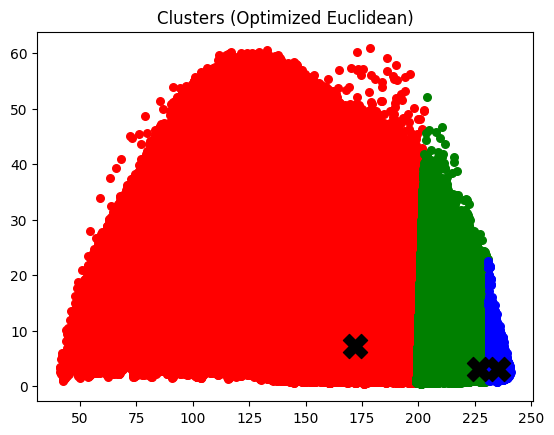

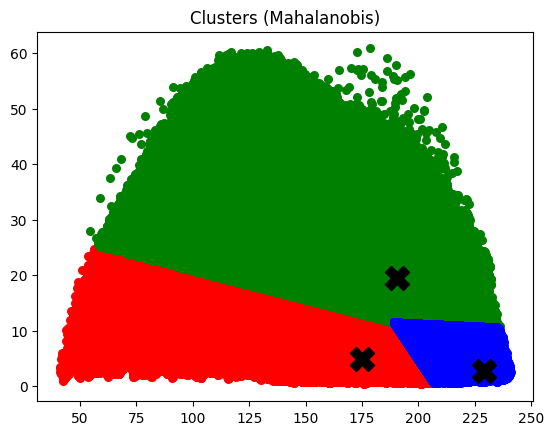

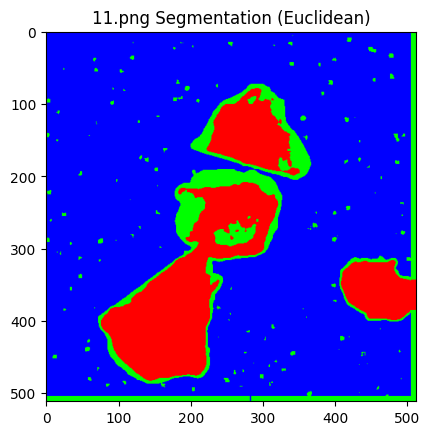

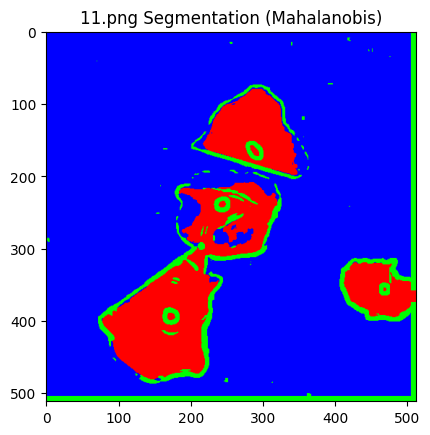

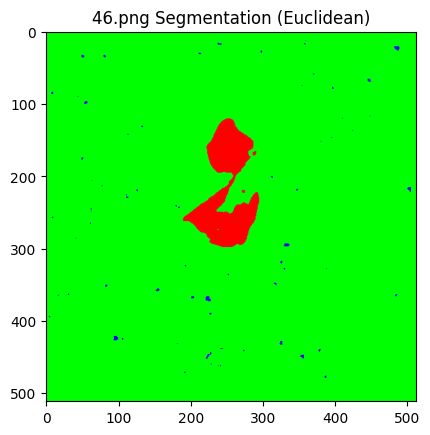

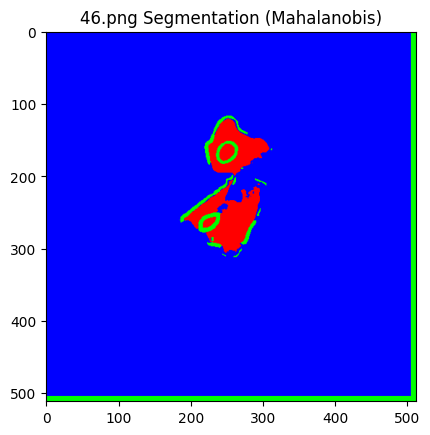

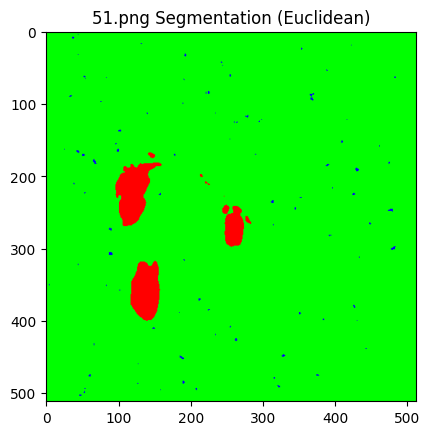

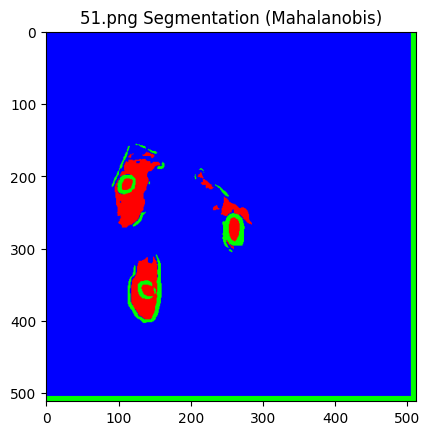

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import cv2

# Helper function to compute mean and standard deviation for each patch
def extract_features(image, patch_size=7, shift=1):
    features = []
    h, w = image.shape

    for i in range(0, h-patch_size+1, shift):
        for j in range(0, w-patch_size+1, shift):
            patch = image[i:i+patch_size, j:j+patch_size]
            mean = np.mean(patch)
            std = np.std(patch)
            features.append([mean, std])

    return np.array(features)

# Function to initialize centroids randomly
def initialize_centroids(data, k):
    indices = np.random.choice(data.shape[0], k, replace=False)
    return data[indices]

# Optimized function to compute Euclidean distances in a vectorized manner
def compute_distances(data, centroids):
    # Use broadcasting to calculate the squared distance between each point and centroid
    dists = np.sqrt(((data[:, np.newaxis] - centroids) ** 2).sum(axis=2))
    return dists

# Optimized K-Means algorithm for Euclidean distance
def kmeans_euclidean_optimized(data, k, max_iters=100):
    centroids = initialize_centroids(data, k)

    for _ in range(max_iters):
        # Compute distances between each data point and each centroid in a vectorized manner
        distances = compute_distances(data, centroids)

        # Assign points to the nearest centroid
        cluster_indices = np.argmin(distances, axis=1)

        # Create empty clusters
        clusters = [[] for _ in range(k)]

        # Populate clusters based on assignments
        for idx, cluster_idx in enumerate(cluster_indices):
            clusters[cluster_idx].append(data[idx])

        # Recompute centroids
        new_centroids = []
        for cluster in clusters:
            if cluster:
                new_centroids.append(np.mean(cluster, axis=0))
            else:
                new_centroids.append(np.random.randn(2))  # Handling empty clusters

        new_centroids = np.array(new_centroids)

        # Check for convergence (if centroids don't change)
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return centroids, clusters

# Optimized Mahalanobis Distance Calculation
def compute_mahalanobis_distances(data, centroids, inv_cov_matrix):
    dists = np.zeros((data.shape[0], centroids.shape[0]))
    for i, centroid in enumerate(centroids):
        diff = data - centroid
        dists[:, i] = np.sqrt(np.sum(diff @ inv_cov_matrix * diff, axis=1))
    return dists

# K-Means algorithm for Mahalanobis distance
def kmeans_mahalanobis(data, k, max_iters=100):
    centroids = initialize_centroids(data, k)
    cov_matrix = np.cov(data.T)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    for _ in range(max_iters):
        # Compute Mahalanobis distances
        distances = compute_mahalanobis_distances(data, centroids, inv_cov_matrix)

        # Assign points to the nearest centroid
        cluster_indices = np.argmin(distances, axis=1)

        # Create empty clusters
        clusters = [[] for _ in range(k)]

        # Populate clusters based on assignments
        for idx, cluster_idx in enumerate(cluster_indices):
            clusters[cluster_idx].append(data[idx])

        # Recompute centroids
        new_centroids = []
        for cluster in clusters:
            if cluster:
                new_centroids.append(np.mean(cluster, axis=0))
            else:
                new_centroids.append(np.random.randn(2))  # Handling empty clusters

        new_centroids = np.array(new_centroids)

        # Check for convergence (if centroids don't change)
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return centroids, clusters

# Plot clusters
def plot_clusters(data, centroids, clusters, title):
    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    for i, cluster in enumerate(clusters):
        cluster = np.array(cluster)
        if len(cluster) > 0:
            plt.scatter(cluster[:, 0], cluster[:, 1], s=30, color=colors[i % len(colors)])
    plt.scatter(centroids[:, 0], centroids[:, 1], s=300, color='black', marker='X')  # Centroids
    plt.title(title)
    plt.show()

# Load images from folder and extract features
def process_images_from_folder(folder_path):
    features = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            feature_vector = extract_features(image)
            features.append(feature_vector)
    return np.vstack(features)

# Segment the test images using the clusters
def segment_image(image, centroids, method="euclidean"):
    h, w = image.shape
    segmented_image = np.zeros((h, w, 3), dtype=np.uint8)  # For RGB segmentation
    features = extract_features(image)

    if method == "euclidean":
        distances = compute_distances(features, centroids)
    elif method == "mahalanobis":
        inv_cov_matrix = np.linalg.inv(np.cov(features.T))
        distances = compute_mahalanobis_distances(features, centroids, inv_cov_matrix)

    cluster_indices = np.argmin(distances, axis=1)

    # Fill segmented image
    for idx, cluster_idx in enumerate(cluster_indices):
        y = idx // (w - 7 + 1)
        x = idx % (w - 7 + 1)

        if cluster_idx == 0:
            color = (255, 0, 0)  # Red for cluster 1
        elif cluster_idx == 1:
            color = (0, 255, 0)  # Green for cluster 2
        else:
            color = (0, 0, 255)  # Blue for cluster 3

        segmented_image[y:y+7, x:x+7] = color

    return segmented_image

# Main code
train_folder = '/content/drive/MyDrive/group07_2c/Train'  # Replace with the path to your training folder
test_folder = '/content/drive/MyDrive/group07_2c/Test'    # Replace with the path to your testing folder

# Process training images and extract feature vectors
train_features = process_images_from_folder(train_folder)

# K-Means with optimized Euclidean Distance
k = 3  # Number of clusters
centroids_euclidean, clusters_euclidean = kmeans_euclidean_optimized(train_features, k)
plot_clusters(train_features, centroids_euclidean, clusters_euclidean, 'Clusters (Optimized Euclidean)')

# K-Means with Mahalanobis Distance
centroids_mahalanobis, clusters_mahalanobis = kmeans_mahalanobis(train_features, k)
plot_clusters(train_features, centroids_mahalanobis, clusters_mahalanobis, 'Clusters (Mahalanobis)')

# Segment all test images
for file_name in os.listdir(test_folder):
    file_path = os.path.join(test_folder, file_name)
    test_image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if test_image is not None:
        # Segment test image using Euclidean and Mahalanobis distance
        segmented_euclidean = segment_image(test_image, centroids_euclidean, method="euclidean")
        segmented_mahalanobis = segment_image(test_image, centroids_mahalanobis, method="mahalanobis")

        plt.imshow(segmented_euclidean)
        plt.title(f'{file_name} Segmentation (Euclidean)')
        plt.show()

        plt.imshow(segmented_mahalanobis)
        plt.title(f'{file_name} Segmentation (Mahalanobis)')
        plt.show()
